# Homework 1 - ML for PP


In [98]:
import requests
import seaborn as sns
import matplotlib.pylab as plt
import geopandas as gp
import pandas as pd
from geopandas.tools import sjoin
from shapely.geometry import Point

## Problem 1: Data Acquisition and Analysis

In [99]:
#Define dict of urls for data acquisition
urls = {}
for year in [2016,2017,2018]:
  urls[year]='https://data.cityofchicago.org/resource/6zsd-86xi.json?year='+str(year)+'&$limit=300000'

In [100]:
#Download data for each year
dfs_raw = {}
for year in [2016,2017,2018]:
  dfs_raw[year]= pd.read_json(urls[year])

In [101]:
#Drop rows with empty values (we are particularly interesting in dropping data without lat, lon)
#Also reset indices
dfs={}
for key, df_raw in dfs_raw.items():
  dfs[key] = df_raw.dropna()
  dfs[key].reset_index(drop=True, inplace=True)

#Check no empty values in dfs
for key, df in dfs.items():
  if df.isnull().values.any():
    print("df "+str(key)+" with nan values")
  

In [102]:
# Generate summary statistics for the crime reports data including but not limited to
# number of crimes of each type, how they change over time, and how they are
# different by neighborhood. Please use a combination of tables and graphs to
# present these summary stats.


#Get frquency of different type of crimes
type_crimes = {}
for year in [2017, 2018]:
  type_crimes[year] = pd.DataFrame(dfs[year].groupby(['primary_type']).size())
  type_crimes[year].columns = [year]
  

In [103]:
#Present a df with types of crimes in each year

#Create unique df with info of types of crimes for both years
#>#Better way of joining dfs: https://www.datacamp.com/community/tutorials/joining-dataframes-pandas
freq_table = type_crimes[2018].add(type_crimes[2017], fill_value=0)
freq_table.index.names = ['Type of Crimes']

#Add totals
for year in [2017,2018]:
  freq_table.loc['TOTAL', year] = dfs[year].count()[0]


#Add rate change
freq_table['% change'] = freq_table[2018]/freq_table[2017]*100-100

#Sort by crimes in 2017
freq_table=freq_table.sort_values(2017,ascending=False)

freq_table

,2017,2018,% change
Type of Crimes,,,
TOTAL,264119.0,262787.0,-0.504318
THEFT,63584.0,64026.0,0.695143
BATTERY,49134.0,49713.0,1.178410
CRIMINAL DAMAGE,28954.0,27700.0,-4.331008
ASSAULT,19250.0,20341.0,5.667532
DECEPTIVE PRACTICE,16966.0,17219.0,1.491218
OTHER OFFENSE,16962.0,16954.0,-0.047164
BURGLARY,12946.0,11687.0,-9.725012
ROBBERY,11870.0,9678.0,-18.466723


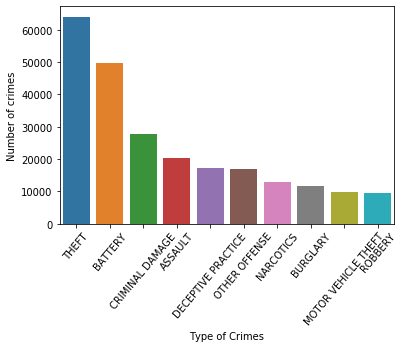

In [104]:
#Bar plot for top 10 types of crimes in 2018
crimes_2018=type_crimes[2018].reset_index()
crimes_2018.sort_values(2018,ascending=False, inplace=True)
top_crimes_2018 = crimes_2018[0:10]
ax = sns.barplot(x="Type of Crimes", y=2018, data=top_crimes_2018)
plt.xticks(rotation=50)
plt.ylabel('Number of crimes')
plt.show()

In [105]:
#Analysis per community area(neighborhood) in 2018

#Group by community area to get amount of crimes
crimes_per_neighborhood = pd.DataFrame(dfs[2018].groupby(['community_area']).size())

#Set community_area as a column
crimes_per_neighborhood.reset_index(level=0, inplace=True)

#Change column type to  to int
crimes_per_neighborhood['community_area'] = crimes_per_neighborhood['community_area'].astype(int)

#Set column name
crimes_per_neighborhood.columns = ['community_area','N of crimes']

In [106]:
#Load neighborhoods geojson
comunities_geojson_url = 'Boundaries - Community Areas (current).geojson'
neighborhoods = gp.read_file(comunities_geojson_url)

#Change column type to  to int
neighborhoods['area_num_1'] = neighborhoods['area_num_1'].astype(int)

In [107]:
#Merge neighborhoods geojson with crimes per neighborhood
neighborhoods_crimes_table = pd.merge(neighborhoods, crimes_per_neighborhood, left_on='area_num_1', right_on='community_area')

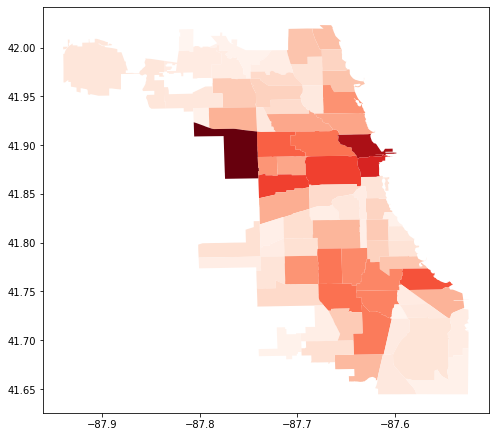

In [108]:
# neighborhoods_crimes_table.dropna(inplace=True)

#Plot heatmap of crimes
neighborhoods_crimes_table.plot('N of crimes', cmap='Reds',figsize=(8, 8))

In [109]:
#Print table with neighborhoods and their % of crimes of total in the city

#Keep only these 2 columns
neighb_crimes_table_to_print = neighborhoods_crimes_table[['community','N of crimes']]
#Change columns names
neighb_crimes_table_to_print.columns=['Neighborhood','N of crimes'] 

#Add column % of total
neighb_crimes_table_to_print['% of total crimes in city'] = neighb_crimes_table_to_print['N of crimes']/sum(neighb_crimes_table_to_print['N of crimes'])*100

#Print list sorted of top 15 neighborhoods by N of crimes
neighb_crimes_table_to_print.sort_values('N of crimes',ascending=False).reset_index(drop=True)[0:15]

,Neighborhood,N of crimes,% of total crimes in city
0,AUSTIN,14921,5.677983
1,NEAR NORTH SIDE,12782,4.864015
2,LOOP,10639,4.048526
3,NORTH LAWNDALE,9229,3.511970
4,NEAR WEST SIDE,9220,3.508545
5,SOUTH SHORE,8558,3.256630
6,HUMBOLDT PARK,7968,3.032113
7,AUBURN GRESHAM,7294,2.775632
8,WEST TOWN,7132,2.713985
9,WEST ENGLEWOOD,7022,2.672126


## Question 2: Data Augmentation and APIs

### 1, 2. What types of blocks have reports of “Battery”? What types of blocks get “Homicide”?

In [110]:
#To describe blocks we will need to join the crime data with census data.
#Crime data has lat,lon for each crime, while census data has tract number,
#so we we will first make a spacial join to get a tract number for each crime
#Later, we will be able to join crimes with the census data

#Remove warning
pd.options.mode.chained_assignment = None  # default='warn'

#Shapefile that enables spacial join from (lat, lon) to geometri points
census_shp = gp.read_file("chicago_census_tracts/census.shp")

def augment_df_with_geographic_data(df):
  '''
  Given a df with lat and long columns, it extends the df with new columns with geometric data of location(particularly with tract number)
  '''
  df=df.reset_index(drop=True)
 
  #Transform each lat,long location of crime to a Point readable by GeoDataFrame
  geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
  crs = {'init' :'epsg:4326'}
  points = gp.GeoDataFrame(crs=crs, geometry=geometry)

  #Spacial Join between the crime Points and the census shape_file, so as to get tract of each point
  pointInPolys = sjoin(points, census_shp, how='left',op="within")

  #Join crime data with geographic data of each point
  df=df.join(pointInPolys, lsuffix='_caller', rsuffix='_other')
  return df

crimes_2018_and_geog = augment_df_with_geographic_data(dfs[2018])
crimes_2017_and_geog = augment_df_with_geographic_data(dfs[2017])


In [111]:
#Get census info

#Define variables we are interested to get from census. Reference: https://api.census.gov/data/2017/acs/acs5/variables.html
NAME='NAME'
MEDIAN_INCOME_CODE='B19013_001E'
TOTAL_POP_CODE='B01003_001E'
WHITE_CODE='B02001_002E'
AFRICAN_AMERICAN_CODE='B02001_003E'

MEDIAN_INCOME='median_income'
TOTAL_POP='total_population'
WHITE='white'
AFRICAN_AMERICAN='african_american'

VARIABLES_OF_INTEREST = [MEDIAN_INCOME, TOTAL_POP, WHITE, AFRICAN_AMERICAN]  

variables_codes=NAME+','+MEDIAN_INCOME_CODE+','+TOTAL_POP_CODE+','+WHITE_CODE+','+AFRICAN_AMERICAN_CODE

key = '5984786462aaccc39f904bf750cc8274bd40f9f8'
census_api_url = 'https://api.census.gov/data/2017/acs/acs5?get='+variables_codes+'&for=tract:*&in=state:17%40county:031&key='+key

def join_crime_data_with_census(crime_df):
  
  #Join between crime data and census based on tract
  crime_and_census = crime_df.join(census, on='tractce10')

  #Rename columns
  crime_and_census=crime_and_census.rename(columns={
    median_income_code: MEDIAN_INCOME, total_population_code: TOTAL_POP, white_code:WHITE,african_american_code:AFRICAN_AMERICAN})

  #Change column types to numeric'
  for column in VARIABLES_OF_INTEREST:
    crime_and_census[column] = pd.to_numeric(crime_and_census[column])
     
  return crime_and_census
  

def group_by_type_crime(crime_2018_and_census):
  '''
  Group by type of crime and get mean of interesting variables
  '''

  #Dictionary mapping each variable of interest to an aggregation function
  agg_functions = {}
  for var in VARIABLES_OF_INTEREST:
    agg_functions[var]='mean'

  type_crime_and_census = pd.DataFrame(crime_2018_and_census.groupby(['primary_type'], as_index=False).agg(agg_functions))

  return type_crime_and_census



def filter_by_crime_type(df, crimes_of_interest):
  
  filtered_data= df.loc[df['primary_type'].isin(crimes_of_interest)]

  return filtered_data

def add_ptg_race(df):

  #Add percentages of whites and african american
  df['% '+WHITE]=df[WHITE]/df[TOTAL_POP]*100
  df['% '+AFRICAN_AMERICAN]=df[AFRICAN_AMERICAN]/df[TOTAL_POP]*100
  
  return df

#We get census data at tract level
census = pd.read_json(census_api_url)

#Move first row to header and then remove first row
census.columns = census.iloc[0] 
census = census.iloc[1:]

#Remove tracts with negative values for median_income
census=census[pd.to_numeric(census[MEDIAN_INCOME_CODE])> 0]

#Set the index for census data to be tract, we need this for join on tract
census=census.set_index('tract')

crimes_2018_and_census = join_crime_data_with_census(crimes_2018_and_geog)

type_crimes_2018_and_census = group_by_type_crime(crimes_2018_and_census)
  
crimes_of_interest=['BATTERY','HOMICIDE']
filtered_by_crime_type = filter_by_crime_type(type_crimes_2018_and_census, crimes_of_interest)

filtered_by_crime_type = add_ptg_race(filtered_by_crime_type)

filtered_by_crime_type


,primary_type,median_income,total_population,white,african_american,% white,% african_american
2,BATTERY,42991.697881,3839.615919,1278.100342,1905.537398,33.287192,49.628334
10,HOMICIDE,34078.385399,3427.497453,648.623090,2312.601019,18.924101,67.471998


In the previous table we can compare the characteristics of the places where crimes related to Battery and Homicide occur. We notice, first of all, that Battery crimes occur in tract areas with higher median income that Homicide crimes (42992 vs 34078). Secondly, we notice that the white population in tracts with Battery Crimes are higher than tracts with Homicide (33% vs 19%). The opposite occurs with the african american population: it is proportionally higher in tracts with Homicide than Battery (67% vs 50%)

### 3. Does that change over time in the data you collected?

In [112]:
crimes_2017_and_census = join_crime_data_with_census(crimes_2017_and_geog)

type_crimes_2017_and_census = group_by_type_crime(crimes_2017_and_census)
  
filtered_by_crime_type = filter_by_crime_type(type_crimes_2017_and_census, crimes_of_interest)

filtered_by_crime_type = add_ptg_race(filtered_by_crime_type)

filtered_by_crime_type

,primary_type,median_income,total_population,white,african_american,% white,% african_american
2,BATTERY,42494.782720,3815.684068,1238.783478,1935.848160,32.465567,50.733974
10,HOMICIDE,34348.811852,3700.980741,698.746667,2457.791111,18.880041,66.409184



When looking at the data from 2017, we can observe that there are no mayor changes in the tendencies.


### 4. What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?

In [113]:
crimes_of_interest=['DECEPTIVE PRACTICE','SEX OFFENSE']


filtered_by_crime_type = filter_by_crime_type(type_crimes_2018_and_census, crimes_of_interest)

filtered_by_crime_type = add_ptg_race(filtered_by_crime_type)

filtered_by_crime_type

,primary_type,median_income,total_population,white,african_american,% white,% african_american
8,DECEPTIVE PRACTICE,64038.187086,4517.759342,2360.987346,1265.836329,52.260140,28.019118
28,SEX OFFENSE,52896.063279,4112.177373,1927.360499,1389.612656,46.869586,33.792624


In this case, we observe higher median_income for tracts that presesent Deceptive Practice than Sex Offense. At the same time, tracts with Deceptive Practice have higher % of white population and lower of african american, compared to tracts with Sex Offense,

## Question 3
### 1. Describe how crime has changed in Chicago from 2017 to 2018?


In [114]:
freq_table.sort_values(2018,ascending=False).head(3)

,2017,2018,% change
Type of Crimes,,,
TOTAL,264119.0,262787.0,-0.504318
THEFT,63584.0,64026.0,0.695143
BATTERY,49134.0,49713.0,1.178410


Between 2017 and 2018, the total amount of crimes in the city barely changed (there was a decrease of 0.5%).

The most common type of crime in 2017 and 2018 was THEFT, followd by BATTERY.

In [115]:
freq_table.sort_values('% change',ascending=False).head(2)

,2017,2018,% change
Type of Crimes,,,
CONCEALED CARRY LICENSE VIOLATION,69.0,148.0,114.492754
HUMAN TRAFFICKING,7.0,12.0,71.428571


The type of crimes that most increased where CONCEALED CARRY LICENSE VIOLATION, from 69 in 2017 to 148 in 2018, and HUMAN TRAFFICKING (which increased in a 75%), from 8 to 14 crimes.


In [116]:
freq_table.sort_values('% change',ascending=True).head(2)

,2017,2018,% change
Type of Crimes,,,
OTHER NARCOTIC VIOLATION,11.0,1.0,-90.909091
ROBBERY,11870.0,9678.0,-18.466723


The type of crimes that most decreased was where ROBBERY (in a 18%) and OTHER NARCOTIC VIOLATION (in a 90%).

### 2. Alderman statistics

In [117]:
#Filter data for ward 43
dfs_43={}
for key, df in dfs.items():
  dfs_43[key] = df[df['ward'] ==43]

#Filter data for selected week
selected_week={}
for year, df in dfs_43.items():
  selected_week[year] = df[(df['date'] > str(year)+'-07-01') & (df['date'] < str(year)+'-07-27')]


In [118]:
#Grouped by type of crime
type_crimes_in_selected_week={}
for year in [2017, 2018]:
  type_crimes_in_selected_week[year] = pd.DataFrame(selected_week[year].groupby(['primary_type']).size())

In [119]:
#Dicts to save stats
stats_year = {}
stats_year[2018]={}
stats_year[2017]={}

crimes_of_interest = ['ROBBERY', 'BATTERY', 'BURGLARY', 'MOTOR VEHICLE THEFT']
for year in [2017, 2018]:
  for crime in crimes_of_interest:
      stats_year[year][crime]=type_crimes_in_selected_week[year].loc[crime][0]

In [121]:
rows = ['Robberies', 'Batteries', 'Burglaries','Motor vehicle']

df = pd.DataFrame(columns=['2017','2018'])
# pd.DataFrame(columns=columns)

for crime in crimes_of_interest:
  df.loc[crime] = [stats_year[2017][crime], stats_year[2018][crime]]

In [122]:
df['Real % change']=(df['2018']/df['2017']-1)*100
df['Alderman announced % change']=[136,50,41,21]
df


,2017,2018,Real % change,Alderman announced % change
ROBBERY,15,8,-46.6667,136
BATTERY,38,30,-21.0526,50
BURGLARY,14,13,-7.14286,41
MOTOR VEHICLE THEFT,6,10,66.6667,21


We first observe that, for the mentioned week, the % change in the different crimes types mentioned by the alderman have no relationship with the real data. This stats are totally misleading: for batteries, burglaries and robberies, the amount of crimes has decreased, not increased as he stated. In the case of motor vehicle crimes, they have increased more than reported by Alderman.

In [123]:
percentage_raise=(selected_week[2018].size/selected_week[2017].size-1)*100
percentage_raise

8.766233766233755

The alderman reports that crime rose 16 percent in the same 28-day time period in just one
year, but the true crime rise was of 8.7%. This is misleading, although it does inform that crime increase for the same 28-day period, the percentage reported is almost double than real.

Lets now consider the year-to-date numbers:

In [124]:
year_to_date = {}
for year in [2016,2017,2018]:
  year_to_date[year] = dfs_43[year][(dfs_43[year]['date'] < str(year)+'-07-27')].size

  
increase_since_2017 = (year_to_date[2018]/year_to_date[2017]-1)*100
increase_since_2016 = (year_to_date[2018]/year_to_date[2016]-1)*100
print(increase_since_2017)
print(increase_since_2016)


9.726156751652493
20.103359173126623


Now the Alderman has more precise numbers. His report of an increase in 10% in the year-to-date since 2017 is accurate. Since 2016 is 20% rather than 22%, but still relatively precise.

## Question 4: 911

### A)

In [125]:
import censusgeocode as cg

#Get comunity area code for the address
address='2111 S Michigan Ave, Chicago, IL'
e=cg.onelineaddress(address)
lon=e[0]['coordinates']['x']
lat=e[0]['coordinates']['y']

#Get point
geometry = [Point(xy) for xy in zip([lon],[lat])]
crs = {'init' :'epsg:4326'}
point = gp.GeoDataFrame(crs=crs, geometry=geometry)

#Spacial Join between the point and shape_file, so as to get community area
point_with_geo_info = sjoin(point, neighborhoods, how='left',op="within")
community_area = int(point_with_geo_info.area_num_1[0])

In [126]:
crimes_33 = dfs[2018].loc[dfs[2018]['community_area'] == community_area]

type_crimes_33 = pd.DataFrame(crimes_33.groupby(['primary_type']).size())
type_crimes_33.columns = ['# of crimes']
type_crimes_33.index.names = ['Type of Crimes']
type_crimes_33=type_crimes_33.sort_values('# of crimes', ascending=False)

total_33 = type_crimes_33['# of crimes'].sum()


type_crimes_33['Fraction of total']=type_crimes_33['# of crimes']/total_33

print(type_crimes_33)

                                   # of crimes  Fraction of total
Type of Crimes                                                   
THEFT                                      583           0.326977
BATTERY                                    278           0.155917
DECEPTIVE PRACTICE                         226           0.126753
CRIMINAL DAMAGE                            187           0.104879
ASSAULT                                    122           0.068424
OTHER OFFENSE                              108           0.060572
MOTOR VEHICLE THEFT                         70           0.039260
CRIMINAL TRESPASS                           49           0.027482
ROBBERY                                     49           0.027482
BURGLARY                                    31           0.017386
NARCOTICS                                   18           0.010095
CRIM SEXUAL ASSAULT                         12           0.006730
WEAPONS VIOLATION                           11           0.006169
SEX OFFENS

Given the data of crimes in 2018, and the crime types in NEAR SOUTH SIDE, it is most likely that the type of crime related to the call is a Theft. The 'Fraction of total' in the previous table is a good aproximation to the probabilities of each type of request.

### B)

In [127]:
# Let’s now assume that a call comes in about Theft. Which is more likely – that the
# call came from Garfield Park or Uptown? How much more or less likely is it to be
# from Garfield Park vs Uptown?

#First filter crimes so as only to have thefts
thefts = dfs[2018].loc[dfs[2018]['primary_type'] == 'THEFT']

#Group by community_areas
thefts = pd.DataFrame(thefts.groupby(['community_area']).size())
thefts.columns = ['# of thefts']


#Join with neighborhoods info to get names of community_areas
thefts_neighborhoods = thefts.join(neighborhoods, on='community_area')
thefts_neighborhoods = thefts_neighborhoods[['# of thefts','community']] #Keep only these 2 columns
thefts_neighborhoods.columns=['# of thefts','Neighborhood'] #Change columns names

#Filter neighborhoods
some_neighbors=['WEST GARFIELD PARK','EAST GARFIELD PARK','UPTOWN']
crimes_uptown_or_garfield=thefts_neighborhoods.loc[thefts_neighborhoods['Neighborhood'].isin(some_neighbors)]
crimes_uptown_or_garfield = crimes_uptown_or_garfield.reset_index()

#Drop community_area code column
crimes_uptown_or_garfield = crimes_uptown_or_garfield.drop(['community_area'], axis=1)

total_garfield = crimes_uptown_or_garfield.loc[0]['# of thefts'] + crimes_uptown_or_garfield.loc[1]['# of thefts']

#Create new row with total for Garfield
crimes_uptown_or_garfield = crimes_uptown_or_garfield.append({'# of thefts' : total_garfield , 'Neighborhood' : 'GARFIELD'} , ignore_index=True)


#Delete previous garfield rows
final_neighbors=['GARFIELD','UPTOWN']
crimes_uptown_or_garfield=crimes_uptown_or_garfield.loc[crimes_uptown_or_garfield['Neighborhood'].isin(final_neighbors)]

print(crimes_uptown_or_garfield)


   # of thefts Neighborhood
2          784       UPTOWN
3         1325     GARFIELD


Considering the amounts of thefts that occured in 2019, we can observe that it is more likely that a new theft will occur in Garfield rather than in Uptown. The following number representes how much more likely is it the theft to be from Garfield Park vs Uptown:

In [128]:
change_likelihood=crimes_uptown_or_garfield.iloc[1]['# of thefts']/crimes_uptown_or_garfield.iloc[0]['# of thefts']-1
print(str(change_likelihood*100)+'%')


69.00510204081634%


### C)

In [129]:
garfield_battery_calls=100
uptown_battery_calls=160
total_battery_calls=garfield_battery_calls+uptown_battery_calls

prob_bat_call_from_garf = garfield_battery_calls/total_battery_calls
prob_bat_call_from_uptown = uptown_battery_calls/total_battery_calls

print(prob_bat_call_from_garf)
print(prob_bat_call_from_uptown)
print(prob_bat_call_from_uptown/prob_bat_call_from_garf)


0.38461538461538464
0.6153846153846154
1.6


If the call is know to be a Battery, then the probability that it is from Garfield is 0.38, while the probability for Uptown is 0.62. So, it is ~60% more likely that the probabiliry is from Uptown than Garfield.
